# Demo of the BGTM on 2-Dimensional Joe-Copula

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 2 dimensional Joe copula.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
from pathlib import Path
import sys

# Add project root (parent of "demos") to sys.path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))


from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv

# Other Stuff
import numpy as np
import torch
from torch.utils.data import DataLoader
from demos.dataset_helpers import Generic_Dataset

/Users/franciscocapunay/miniforge3/envs/gtm-magic-env-3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a Joe Copula and add Gaussian marginals. Feel free to exchange the copula parameter, the rotation or even the copula itsself.
The list of copulas can be found with `help(pv.Bicop)`.

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [2]:
copula_pv = pv.Bicop(family=pv.BicopFamily.joe, parameters=np.array([[2.5]]), rotation=90)

# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

In [3]:
loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = torch.tensor(loglik_copula) + log_marginals

/var/folders/_p/ttn2qcdj23jdpltyffhwq9pr0000gn/T/ipykernel_62481/2085715786.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/var/folders/_p/ttn2qcdj23jdpltyffhwq9pr0000gn/T/ipykernel_62481/2085715786.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/var/folders/_p/ttn2qcdj23jdpltyffhwq9pr0000gn/T/ipykernel_62481/2085715786.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [4]:
copula_pv_est = pv.Bicop(family=pv.BicopFamily.joe, rotation=90)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

In [5]:
loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = torch.tensor(loglik_copula) + log_marginals

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [6]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [7]:
hyperparameters = {
    "transformation": {
    "sigma_a": 2, "sigma_b": 10,        # mean σ² = 10 (weak)
    "RW2": { "tau_a": 2, "tau_b": 0.2 },# mean τ² = 0.2 (keep marginals ~identity)
    "RW1": { "tau_a": 10,"tau_b": 15 }  #Ignored
    },
    "decorrelation": {
    "sigma_a": 2, "sigma_b": 10,        # mean σ² = 10 (weak)
    "RW1": { "tau_a": 2, "tau_b": 0.3 },# mean τ₁² = 0.3 (strong pull-to-linear)
    "RW2": { "tau_a": 2, "tau_b": 1.0 } # mean τ₂² = 1.0 (moderate curvature smoothing)
    }
}



model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=3,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    inference = 'bayesian',
    device="cpu",
    hyperparameter=hyperparameters
    )


device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
_=model

The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

In [8]:
#model.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

150


In [9]:
#model.plot_marginals(simulated_data_train)

### 3. Hyperparameter Tune and Train Model

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [10]:
output = model.fit_bayes(
                train_dataloader=dataloader_train,
                validate_dataloader=dataloader_validate,
                hyperparameters=None,
                iterations=1000,
                verbose=True,
                lr=0.01,
                mcmc_sample_train=4,            # will ramp
                mcmc_sample_val=16,             # fixed & larger for stable eval
                mc_ramp_every=25,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=32,
                patience_val=15,                # early-stop patience
                min_delta=0.001,                # ~0.1% absolute of your loss scale
                rho_lr_multiplier=1.5,          # slightly faster variance adaption (optional)
                sched_factor=0.5, sched_patience=6, sched_threshold=1e-4,
            )

/Users/franciscocapunay/miniforge3/envs/gtm-magic-env-3.11/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
  0%|          | 0/1000 [00:00<?, ?it/s]/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:595: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3641.)
  x=input_a_clone.T, t=knots.T, c=params_a.

[1/1000] train=235.4218  val=236.7897  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0507  σmin=0.0507  σmax=0.0507


  0%|          | 2/1000 [00:01<13:17,  1.25it/s]

[2/1000] train=228.9854  val=234.5889  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0515  σmin=0.0515  σmax=0.0515


  0%|          | 3/1000 [00:02<09:15,  1.79it/s]

[3/1000] train=227.0761  val=232.3892  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0522  σmin=0.0522  σmax=0.0522


  0%|          | 4/1000 [00:02<07:23,  2.25it/s]

[4/1000] train=223.5429  val=230.1912  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0530  σmin=0.0530  σmax=0.0530


  0%|          | 5/1000 [00:02<06:20,  2.61it/s]

[5/1000] train=222.9425  val=227.9942  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0538  σmin=0.0538  σmax=0.0538


  1%|          | 6/1000 [00:02<05:45,  2.87it/s]

[6/1000] train=230.9125  val=225.7980  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0546  σmin=0.0546  σmax=0.0546


  1%|          | 7/1000 [00:03<05:25,  3.05it/s]

[7/1000] train=217.7563  val=223.6030  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0554  σmin=0.0554  σmax=0.0554


  1%|          | 8/1000 [00:03<05:28,  3.02it/s]

[8/1000] train=220.4632  val=221.4095  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0562  σmin=0.0562  σmax=0.0562


  1%|          | 9/1000 [00:03<05:12,  3.17it/s]

[9/1000] train=216.8755  val=219.2175  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0570  σmin=0.0570  σmax=0.0570


  1%|          | 10/1000 [00:04<05:22,  3.07it/s]

[10/1000] train=215.3682  val=217.0267  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0579  σmin=0.0579  σmax=0.0579


  1%|          | 11/1000 [00:04<05:37,  2.93it/s]

[11/1000] train=219.0710  val=214.8367  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0587  σmin=0.0587  σmax=0.0587


  1%|          | 12/1000 [00:05<06:42,  2.45it/s]

[12/1000] train=216.3811  val=212.6479  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0596  σmin=0.0596  σmax=0.0596


  1%|▏         | 13/1000 [00:05<06:52,  2.39it/s]

[13/1000] train=217.2578  val=210.4601  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0604  σmin=0.0604  σmax=0.0604


  1%|▏         | 14/1000 [00:05<07:00,  2.34it/s]

[14/1000] train=220.5456  val=208.2728  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0613  σmin=0.0613  σmax=0.0613


  2%|▏         | 15/1000 [00:06<08:12,  2.00it/s]

[15/1000] train=207.6996  val=206.0871  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0622  σmin=0.0622  σmax=0.0622


  2%|▏         | 16/1000 [00:07<08:36,  1.91it/s]

[16/1000] train=207.4722  val=203.9026  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0631  σmin=0.0631  σmax=0.0631


  2%|▏         | 17/1000 [00:07<07:53,  2.08it/s]

[17/1000] train=200.5350  val=201.7195  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0641  σmin=0.0641  σmax=0.0641


  2%|▏         | 18/1000 [00:07<07:10,  2.28it/s]

[18/1000] train=203.9277  val=199.5375  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0650  σmin=0.0650  σmax=0.0650


  2%|▏         | 19/1000 [00:08<06:38,  2.46it/s]

[19/1000] train=195.0790  val=197.3566  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0660  σmin=0.0660  σmax=0.0660


  2%|▏         | 20/1000 [00:08<06:32,  2.50it/s]

[20/1000] train=201.3701  val=195.1769  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0669  σmin=0.0669  σmax=0.0669


  2%|▏         | 21/1000 [00:09<06:37,  2.46it/s]

[21/1000] train=188.1659  val=192.9982  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0679  σmin=0.0679  σmax=0.0679


  2%|▏         | 22/1000 [00:09<06:12,  2.63it/s]

[22/1000] train=193.8512  val=190.8211  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0689  σmin=0.0689  σmax=0.0689


  2%|▏         | 23/1000 [00:09<05:36,  2.90it/s]

[23/1000] train=184.2953  val=188.6454  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0699  σmin=0.0699  σmax=0.0699


  2%|▏         | 24/1000 [00:09<05:15,  3.10it/s]

[24/1000] train=193.3686  val=186.4715  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0709  σmin=0.0709  σmax=0.0709


  2%|▎         | 25/1000 [00:10<04:58,  3.27it/s]

[25/1000] train=184.2382  val=184.2985  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0719  σmin=0.0719  σmax=0.0720


  3%|▎         | 26/1000 [00:10<05:08,  3.16it/s]

[26/1000] train=180.6219  val=182.1261  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0730  σmin=0.0730  σmax=0.0730


  3%|▎         | 27/1000 [00:10<05:21,  3.03it/s]

[27/1000] train=180.3661  val=179.9548  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0741  σmin=0.0741  σmax=0.0741


  3%|▎         | 28/1000 [00:11<05:28,  2.96it/s]

[28/1000] train=178.1952  val=177.7841  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0751  σmin=0.0751  σmax=0.0751


  3%|▎         | 29/1000 [00:11<05:33,  2.91it/s]

[29/1000] train=171.4048  val=175.6152  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0762  σmin=0.0762  σmax=0.0762


  3%|▎         | 30/1000 [00:12<05:38,  2.86it/s]

[30/1000] train=180.1386  val=173.4480  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0773  σmin=0.0773  σmax=0.0773


  3%|▎         | 31/1000 [00:12<05:38,  2.86it/s]

[31/1000] train=173.2178  val=171.2822  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0785  σmin=0.0785  σmax=0.0785


  3%|▎         | 32/1000 [00:12<05:49,  2.77it/s]

[32/1000] train=172.1723  val=169.1170  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0796  σmin=0.0796  σmax=0.0796


  3%|▎         | 33/1000 [00:13<05:59,  2.69it/s]

[33/1000] train=166.9455  val=166.9531  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0808  σmin=0.0808  σmax=0.0808


  3%|▎         | 34/1000 [00:13<06:02,  2.66it/s]

[34/1000] train=164.6611  val=164.7908  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0819  σmin=0.0819  σmax=0.0819


  4%|▎         | 35/1000 [00:13<05:56,  2.70it/s]

[35/1000] train=164.4795  val=162.6298  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0831  σmin=0.0831  σmax=0.0831


  4%|▎         | 36/1000 [00:14<05:53,  2.73it/s]

[36/1000] train=162.3871  val=160.4703  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0843  σmin=0.0843  σmax=0.0843


  4%|▎         | 37/1000 [00:14<05:48,  2.76it/s]

[37/1000] train=158.9257  val=158.3123  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0855  σmin=0.0855  σmax=0.0856


  4%|▍         | 38/1000 [00:15<06:12,  2.58it/s]

[38/1000] train=151.6671  val=156.1559  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0868  σmin=0.0868  σmax=0.0868


  4%|▍         | 39/1000 [00:15<06:00,  2.66it/s]

[39/1000] train=154.2914  val=154.0008  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0880  σmin=0.0880  σmax=0.0880


  4%|▍         | 40/1000 [00:15<05:55,  2.70it/s]

[40/1000] train=153.7924  val=151.8466  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0893  σmin=0.0893  σmax=0.0893


  4%|▍         | 41/1000 [00:16<05:49,  2.74it/s]

[41/1000] train=154.8793  val=149.6938  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0906  σmin=0.0906  σmax=0.0906


  4%|▍         | 42/1000 [00:16<05:44,  2.78it/s]

[42/1000] train=154.7807  val=147.5426  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0919  σmin=0.0919  σmax=0.0919


  4%|▍         | 43/1000 [00:16<05:43,  2.78it/s]

[43/1000] train=145.1969  val=145.3931  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0932  σmin=0.0932  σmax=0.0932


  4%|▍         | 44/1000 [00:17<05:41,  2.80it/s]

[44/1000] train=138.5216  val=143.2455  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0946  σmin=0.0946  σmax=0.0946


  4%|▍         | 45/1000 [00:17<05:40,  2.81it/s]

[45/1000] train=143.4088  val=141.0998  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0959  σmin=0.0959  σmax=0.0960


  5%|▍         | 46/1000 [00:17<05:41,  2.79it/s]

[46/1000] train=141.6763  val=138.9561  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0973  σmin=0.0973  σmax=0.0973


  5%|▍         | 47/1000 [00:18<05:47,  2.74it/s]

[47/1000] train=137.5398  val=136.8145  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0987  σmin=0.0987  σmax=0.0987


  5%|▍         | 48/1000 [00:18<05:43,  2.78it/s]

[48/1000] train=135.8382  val=134.6734  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.1001  σmin=0.1001  σmax=0.1002


  5%|▍         | 49/1000 [00:18<05:38,  2.81it/s]

[49/1000] train=134.3557  val=132.5332  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.1016  σmin=0.1015  σmax=0.1016


  5%|▌         | 50/1000 [00:19<05:38,  2.80it/s]

[50/1000] train=132.8977  val=130.3932  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.1030  σmin=0.1030  σmax=0.1031


  5%|▌         | 51/1000 [00:19<06:30,  2.43it/s]

[51/1000] train=130.9484  val=128.2544  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1045  σmin=0.1045  σmax=0.1045


  5%|▌         | 52/1000 [00:20<07:06,  2.22it/s]

[52/1000] train=125.4952  val=126.1169  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1060  σmin=0.1060  σmax=0.1060


  5%|▌         | 53/1000 [00:20<07:29,  2.11it/s]

[53/1000] train=124.8553  val=123.9822  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1075  σmin=0.1075  σmax=0.1076


  5%|▌         | 54/1000 [00:21<07:43,  2.04it/s]

[54/1000] train=121.8811  val=121.8493  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1091  σmin=0.1090  σmax=0.1091


  6%|▌         | 55/1000 [00:21<07:54,  1.99it/s]

[55/1000] train=124.5738  val=119.7185  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1106  σmin=0.1106  σmax=0.1107


  6%|▌         | 56/1000 [00:22<08:00,  1.96it/s]

[56/1000] train=114.7777  val=117.5899  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1122  σmin=0.1121  σmax=0.1122


  6%|▌         | 57/1000 [00:23<08:09,  1.93it/s]

[57/1000] train=114.2893  val=115.4626  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1138  σmin=0.1137  σmax=0.1138


  6%|▌         | 58/1000 [00:23<08:11,  1.92it/s]

[58/1000] train=115.6431  val=113.3368  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1155  σmin=0.1154  σmax=0.1155


  6%|▌         | 59/1000 [00:24<08:15,  1.90it/s]

[59/1000] train=113.0481  val=111.2130  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1171  σmin=0.1170  σmax=0.1171


  6%|▌         | 60/1000 [00:24<08:15,  1.90it/s]

[60/1000] train=110.4242  val=109.0911  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1188  σmin=0.1187  σmax=0.1188


  6%|▌         | 61/1000 [00:25<08:15,  1.89it/s]

[61/1000] train=105.8922  val=106.9709  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1205  σmin=0.1204  σmax=0.1205


  6%|▌         | 62/1000 [00:25<08:11,  1.91it/s]

[62/1000] train=105.8831  val=104.8526  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1222  σmin=0.1221  σmax=0.1222


  6%|▋         | 63/1000 [00:26<08:14,  1.89it/s]

[63/1000] train=103.7725  val=102.7361  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1239  σmin=0.1238  σmax=0.1239


  6%|▋         | 64/1000 [00:26<08:37,  1.81it/s]

[64/1000] train=103.1451  val=100.6212  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1257  σmin=0.1255  σmax=0.1257


  6%|▋         | 65/1000 [00:27<08:50,  1.76it/s]

[65/1000] train=101.3927  val=98.5082  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1275  σmin=0.1273  σmax=0.1275


  7%|▋         | 66/1000 [00:27<08:39,  1.80it/s]

[66/1000] train=98.4353  val=96.3970  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1293  σmin=0.1291  σmax=0.1293


  7%|▋         | 67/1000 [00:28<08:29,  1.83it/s]

[67/1000] train=96.8630  val=94.2880  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1311  σmin=0.1309  σmax=0.1311


  7%|▋         | 68/1000 [00:29<08:25,  1.84it/s]

[68/1000] train=94.4353  val=92.1810  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1329  σmin=0.1328  σmax=0.1330


  7%|▋         | 69/1000 [00:29<08:21,  1.86it/s]

[69/1000] train=88.2209  val=90.0761  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1348  σmin=0.1346  σmax=0.1348


  7%|▋         | 70/1000 [00:30<08:17,  1.87it/s]

[70/1000] train=88.3962  val=87.9733  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1367  σmin=0.1365  σmax=0.1368


  7%|▋         | 71/1000 [00:30<08:13,  1.88it/s]

[71/1000] train=85.0276  val=85.8721  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1387  σmin=0.1384  σmax=0.1387


  7%|▋         | 72/1000 [00:31<08:15,  1.87it/s]

[72/1000] train=84.4608  val=83.7733  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1406  σmin=0.1404  σmax=0.1406


  7%|▋         | 73/1000 [00:31<08:16,  1.87it/s]

[73/1000] train=78.5575  val=81.6766  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1426  σmin=0.1423  σmax=0.1426


  7%|▋         | 74/1000 [00:32<08:16,  1.87it/s]

[74/1000] train=81.0454  val=79.5834  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1446  σmin=0.1443  σmax=0.1446


  8%|▊         | 75/1000 [00:32<08:52,  1.74it/s]

[75/1000] train=77.0582  val=77.4919  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1466  σmin=0.1463  σmax=0.1467


  8%|▊         | 76/1000 [00:33<10:17,  1.50it/s]

[76/1000] train=74.7366  val=75.4034  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1487  σmin=0.1484  σmax=0.1487


  8%|▊         | 77/1000 [00:34<11:24,  1.35it/s]

[77/1000] train=74.3190  val=73.3170  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1508  σmin=0.1505  σmax=0.1508


  8%|▊         | 78/1000 [00:35<12:09,  1.26it/s]

[78/1000] train=71.7802  val=71.2316  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1529  σmin=0.1526  σmax=0.1529


  8%|▊         | 79/1000 [00:36<12:42,  1.21it/s]

[79/1000] train=70.1794  val=69.1465  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1550  σmin=0.1547  σmax=0.1551


  8%|▊         | 80/1000 [00:37<13:07,  1.17it/s]

[80/1000] train=69.5616  val=67.0632  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1572  σmin=0.1568  σmax=0.1572


  8%|▊         | 81/1000 [00:38<13:26,  1.14it/s]

[81/1000] train=63.3244  val=64.9819  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1594  σmin=0.1590  σmax=0.1594


  8%|▊         | 82/1000 [00:39<13:32,  1.13it/s]

[82/1000] train=63.8258  val=62.9032  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1616  σmin=0.1612  σmax=0.1616


  8%|▊         | 83/1000 [00:40<13:37,  1.12it/s]

[83/1000] train=62.8465  val=60.8279  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1639  σmin=0.1634  σmax=0.1639


  8%|▊         | 84/1000 [00:41<13:34,  1.12it/s]

[84/1000] train=58.7511  val=58.7556  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1661  σmin=0.1657  σmax=0.1662


  8%|▊         | 85/1000 [00:42<14:06,  1.08it/s]

[85/1000] train=57.7328  val=56.6866  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1685  σmin=0.1680  σmax=0.1685


  9%|▊         | 86/1000 [00:42<13:56,  1.09it/s]

[86/1000] train=56.1408  val=54.6198  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1708  σmin=0.1703  σmax=0.1708


  9%|▊         | 87/1000 [00:43<14:09,  1.07it/s]

[87/1000] train=52.4326  val=52.5553  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1732  σmin=0.1727  σmax=0.1732


  9%|▉         | 88/1000 [00:45<15:35,  1.03s/it]

[88/1000] train=52.0088  val=50.4919  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1756  σmin=0.1750  σmax=0.1756


  9%|▉         | 89/1000 [00:46<18:13,  1.20s/it]

[89/1000] train=51.0552  val=48.4307  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1780  σmin=0.1774  σmax=0.1780


  9%|▉         | 90/1000 [00:47<17:43,  1.17s/it]

[90/1000] train=46.2267  val=46.3720  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1805  σmin=0.1799  σmax=0.1805


  9%|▉         | 91/1000 [00:48<16:57,  1.12s/it]

[91/1000] train=44.8366  val=44.3165  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1830  σmin=0.1823  σmax=0.1830


  9%|▉         | 92/1000 [00:51<23:33,  1.56s/it]

[92/1000] train=42.4962  val=42.2645  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1855  σmin=0.1848  σmax=0.1855


  9%|▉         | 93/1000 [00:52<21:31,  1.42s/it]

[93/1000] train=39.8414  val=40.2155  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1880  σmin=0.1873  σmax=0.1881


  9%|▉         | 94/1000 [00:53<19:54,  1.32s/it]

[94/1000] train=42.6095  val=38.1689  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1906  σmin=0.1899  σmax=0.1907


 10%|▉         | 95/1000 [00:54<18:35,  1.23s/it]

[95/1000] train=37.6158  val=36.1249  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1932  σmin=0.1924  σmax=0.1933


 10%|▉         | 96/1000 [00:55<18:06,  1.20s/it]

[96/1000] train=35.3542  val=34.0830  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1959  σmin=0.1950  σmax=0.1959


 10%|▉         | 97/1000 [00:56<17:51,  1.19s/it]

[97/1000] train=34.9425  val=32.0437  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1986  σmin=0.1977  σmax=0.1986


 10%|▉         | 98/1000 [00:58<17:32,  1.17s/it]

[98/1000] train=28.8214  val=30.0070  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2013  σmin=0.2004  σmax=0.2014


 10%|▉         | 99/1000 [00:59<16:46,  1.12s/it]

[99/1000] train=29.4019  val=27.9732  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2040  σmin=0.2031  σmax=0.2041


 10%|█         | 100/1000 [01:00<16:13,  1.08s/it]

[100/1000] train=27.2655  val=25.9433  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2068  σmin=0.2058  σmax=0.2069


 10%|█         | 101/1000 [01:01<16:08,  1.08s/it]

[101/1000] train=24.0316  val=23.9161  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2097  σmin=0.2086  σmax=0.2097


 10%|█         | 102/1000 [01:03<21:27,  1.43s/it]

[102/1000] train=21.7266  val=21.8923  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2125  σmin=0.2114  σmax=0.2126


 10%|█         | 103/1000 [01:04<20:03,  1.34s/it]

[103/1000] train=19.4220  val=19.8704  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2154  σmin=0.2142  σmax=0.2155


 10%|█         | 104/1000 [01:05<18:49,  1.26s/it]

[104/1000] train=20.9943  val=17.8499  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2183  σmin=0.2171  σmax=0.2184


 10%|█         | 105/1000 [01:07<20:15,  1.36s/it]

[105/1000] train=16.0015  val=15.8315  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2213  σmin=0.2200  σmax=0.2214


 11%|█         | 106/1000 [01:08<21:17,  1.43s/it]

[106/1000] train=13.6410  val=13.8156  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2243  σmin=0.2229  σmax=0.2244


 11%|█         | 107/1000 [01:10<20:43,  1.39s/it]

[107/1000] train=11.5004  val=11.8036  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2273  σmin=0.2258  σmax=0.2274


 11%|█         | 108/1000 [01:11<18:56,  1.27s/it]

[108/1000] train=11.0472  val=9.7956  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2304  σmin=0.2288  σmax=0.2305


 11%|█         | 109/1000 [01:12<18:01,  1.21s/it]

[109/1000] train=9.6119  val=7.7918  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2335  σmin=0.2319  σmax=0.2336


 11%|█         | 110/1000 [01:13<17:58,  1.21s/it]

[110/1000] train=7.5545  val=5.7909  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2366  σmin=0.2349  σmax=0.2367


 11%|█         | 111/1000 [01:14<17:31,  1.18s/it]

[111/1000] train=4.2031  val=3.7929  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2398  σmin=0.2380  σmax=0.2399


 11%|█         | 112/1000 [01:15<16:51,  1.14s/it]

[112/1000] train=4.7019  val=1.7972  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2430  σmin=0.2411  σmax=0.2431


 11%|█▏        | 113/1000 [01:16<16:38,  1.13s/it]

[113/1000] train=0.2977  val=-0.1951  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2463  σmin=0.2443  σmax=0.2464


 11%|█▏        | 114/1000 [01:17<16:30,  1.12s/it]

[114/1000] train=-0.0672  val=-2.1839  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2496  σmin=0.2475  σmax=0.2497


 12%|█▏        | 115/1000 [01:18<15:57,  1.08s/it]

[115/1000] train=-2.9218  val=-4.1688  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2529  σmin=0.2508  σmax=0.2530


 12%|█▏        | 116/1000 [01:19<15:38,  1.06s/it]

[116/1000] train=-3.7790  val=-6.1491  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2563  σmin=0.2541  σmax=0.2564


 12%|█▏        | 117/1000 [01:20<15:43,  1.07s/it]

[117/1000] train=-6.9464  val=-8.1244  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2597  σmin=0.2574  σmax=0.2598


 12%|█▏        | 118/1000 [01:21<15:11,  1.03s/it]

[118/1000] train=-8.2436  val=-10.0963  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2631  σmin=0.2608  σmax=0.2633


 12%|█▏        | 119/1000 [01:22<14:48,  1.01s/it]

[119/1000] train=-10.5669  val=-12.0635  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2666  σmin=0.2642  σmax=0.2668


 12%|█▏        | 120/1000 [01:23<14:32,  1.01it/s]

[120/1000] train=-14.9912  val=-14.0274  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2702  σmin=0.2676  σmax=0.2703


 12%|█▏        | 121/1000 [01:24<14:33,  1.01it/s]

[121/1000] train=-15.3842  val=-15.9884  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2737  σmin=0.2711  σmax=0.2739


 12%|█▏        | 122/1000 [01:25<14:48,  1.01s/it]

[122/1000] train=-19.0010  val=-17.9503  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2773  σmin=0.2746  σmax=0.2775


 12%|█▏        | 123/1000 [01:28<23:40,  1.62s/it]

[123/1000] train=-20.2598  val=-19.9127  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2810  σmin=0.2782  σmax=0.2812


 12%|█▏        | 124/1000 [01:29<22:03,  1.51s/it]

[124/1000] train=-23.0827  val=-21.8716  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2847  σmin=0.2818  σmax=0.2849


 12%|█▎        | 125/1000 [01:31<19:58,  1.37s/it]

[125/1000] train=-24.3146  val=-23.8283  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2884  σmin=0.2854  σmax=0.2886


 13%|█▎        | 126/1000 [01:32<18:45,  1.29s/it]

[126/1000] train=-24.2093  val=-25.7783  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2922  σmin=0.2890  σmax=0.2924


 13%|█▎        | 127/1000 [01:33<18:09,  1.25s/it]

[127/1000] train=-28.8365  val=-27.7208  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2960  σmin=0.2927  σmax=0.2963


 13%|█▎        | 128/1000 [01:34<18:21,  1.26s/it]

[128/1000] train=-29.3560  val=-29.6567  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2999  σmin=0.2965  σmax=0.3001


 13%|█▎        | 129/1000 [01:36<20:25,  1.41s/it]

[129/1000] train=-30.3070  val=-31.5861  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3038  σmin=0.3002  σmax=0.3041


 13%|█▎        | 130/1000 [01:38<21:39,  1.49s/it]

[130/1000] train=-33.8996  val=-33.5150  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3077  σmin=0.3040  σmax=0.3080


 13%|█▎        | 131/1000 [01:39<22:21,  1.54s/it]

[131/1000] train=-36.0347  val=-35.4436  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3117  σmin=0.3079  σmax=0.3120


 13%|█▎        | 132/1000 [01:41<21:44,  1.50s/it]

[132/1000] train=-35.3567  val=-37.3682  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3158  σmin=0.3117  σmax=0.3161


 13%|█▎        | 133/1000 [01:42<19:51,  1.37s/it]

[133/1000] train=-39.9807  val=-39.2911  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3198  σmin=0.3156  σmax=0.3202


 13%|█▎        | 134/1000 [01:43<18:03,  1.25s/it]

[134/1000] train=-38.0806  val=-41.2107  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3240  σmin=0.3196  σmax=0.3243


 14%|█▎        | 135/1000 [01:44<18:22,  1.27s/it]

[135/1000] train=-39.2440  val=-43.1247  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3281  σmin=0.3235  σmax=0.3285


 14%|█▎        | 136/1000 [01:45<17:59,  1.25s/it]

[136/1000] train=-43.3107  val=-45.0301  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3324  σmin=0.3275  σmax=0.3327


 14%|█▎        | 137/1000 [01:47<18:27,  1.28s/it]

[137/1000] train=-44.8076  val=-46.9261  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3366  σmin=0.3316  σmax=0.3370


 14%|█▍        | 138/1000 [01:48<17:16,  1.20s/it]

[138/1000] train=-47.7498  val=-48.8135  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3409  σmin=0.3357  σmax=0.3413


 14%|█▍        | 139/1000 [01:50<20:52,  1.45s/it]

[139/1000] train=-48.1886  val=-50.7015  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3453  σmin=0.3398  σmax=0.3457


 14%|█▍        | 140/1000 [01:51<22:03,  1.54s/it]

[140/1000] train=-53.0532  val=-52.5928  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3497  σmin=0.3439  σmax=0.3501


 14%|█▍        | 141/1000 [01:52<19:47,  1.38s/it]

[141/1000] train=-52.6119  val=-54.4839  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3541  σmin=0.3482  σmax=0.3546


 14%|█▍        | 142/1000 [01:53<18:08,  1.27s/it]

[142/1000] train=-56.4418  val=-56.3701  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3586  σmin=0.3524  σmax=0.3591


 14%|█▍        | 143/1000 [01:54<17:11,  1.20s/it]

[143/1000] train=-54.1688  val=-58.2508  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3632  σmin=0.3567  σmax=0.3637


 14%|█▍        | 144/1000 [01:55<16:07,  1.13s/it]

[144/1000] train=-59.8868  val=-60.1294  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3677  σmin=0.3611  σmax=0.3683


 14%|█▍        | 145/1000 [01:56<15:18,  1.07s/it]

[145/1000] train=-63.9305  val=-62.0028  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3724  σmin=0.3655  σmax=0.3729


 15%|█▍        | 146/1000 [01:57<15:02,  1.06s/it]

[146/1000] train=-64.0978  val=-63.8715  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3771  σmin=0.3698  σmax=0.3776


 15%|█▍        | 147/1000 [01:58<14:59,  1.05s/it]

[147/1000] train=-65.3845  val=-65.7357  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3818  σmin=0.3743  σmax=0.3824


 15%|█▍        | 148/1000 [01:59<15:11,  1.07s/it]

[148/1000] train=-67.3648  val=-67.5953  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3866  σmin=0.3787  σmax=0.3872


 15%|█▍        | 149/1000 [02:01<15:24,  1.09s/it]

[149/1000] train=-68.3809  val=-69.4479  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3914  σmin=0.3833  σmax=0.3920


 15%|█▌        | 150/1000 [02:02<15:56,  1.13s/it]

[150/1000] train=-69.3775  val=-71.2931  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3963  σmin=0.3878  σmax=0.3969


 15%|█▌        | 151/1000 [02:03<15:58,  1.13s/it]

[151/1000] train=-72.1322  val=-73.1330  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4012  σmin=0.3925  σmax=0.4019


 15%|█▌        | 152/1000 [02:04<15:42,  1.11s/it]

[152/1000] train=-75.9587  val=-74.9694  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4062  σmin=0.3971  σmax=0.4069


 15%|█▌        | 153/1000 [02:05<15:13,  1.08s/it]

[153/1000] train=-78.5467  val=-76.8039  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4112  σmin=0.4018  σmax=0.4120


 15%|█▌        | 154/1000 [02:06<14:49,  1.05s/it]

[154/1000] train=-80.7353  val=-78.6336  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4163  σmin=0.4065  σmax=0.4171


 16%|█▌        | 155/1000 [02:07<14:38,  1.04s/it]

[155/1000] train=-78.0156  val=-80.4595  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4214  σmin=0.4113  σmax=0.4222


 16%|█▌        | 156/1000 [02:08<15:58,  1.14s/it]

[156/1000] train=-82.3125  val=-82.2814  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4266  σmin=0.4160  σmax=0.4275


 16%|█▌        | 157/1000 [02:09<15:43,  1.12s/it]

[157/1000] train=-82.5645  val=-84.0984  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4319  σmin=0.4208  σmax=0.4327


 16%|█▌        | 158/1000 [02:11<15:56,  1.14s/it]

[158/1000] train=-85.4856  val=-85.9096  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4371  σmin=0.4256  σmax=0.4380


 16%|█▌        | 159/1000 [02:12<15:49,  1.13s/it]

[159/1000] train=-86.5572  val=-87.7144  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4425  σmin=0.4305  σmax=0.4434


 16%|█▌        | 160/1000 [02:13<16:44,  1.20s/it]

[160/1000] train=-88.6699  val=-89.5129  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4479  σmin=0.4353  σmax=0.4488


 16%|█▌        | 161/1000 [02:14<17:33,  1.26s/it]

[161/1000] train=-87.9521  val=-91.3069  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4533  σmin=0.4402  σmax=0.4543


 16%|█▌        | 162/1000 [02:16<20:05,  1.44s/it]

[162/1000] train=-91.7937  val=-93.0939  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4588  σmin=0.4451  σmax=0.4599


 16%|█▋        | 163/1000 [02:17<18:44,  1.34s/it]

[163/1000] train=-92.3960  val=-94.8757  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4643  σmin=0.4501  σmax=0.4654


 16%|█▋        | 164/1000 [02:19<17:41,  1.27s/it]

[164/1000] train=-97.2872  val=-96.6568  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4699  σmin=0.4551  σmax=0.4711


 16%|█▋        | 165/1000 [02:20<17:22,  1.25s/it]

[165/1000] train=-96.1452  val=-98.4320  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4756  σmin=0.4601  σmax=0.4768


 17%|█▋        | 166/1000 [02:21<17:35,  1.27s/it]

[166/1000] train=-99.1537  val=-100.2035  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4813  σmin=0.4652  σmax=0.4825


 17%|█▋        | 167/1000 [02:23<19:56,  1.44s/it]

[167/1000] train=-102.5311  val=-101.9679  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4870  σmin=0.4703  σmax=0.4883


 17%|█▋        | 168/1000 [02:27<31:34,  2.28s/it]

[168/1000] train=-102.7248  val=-103.7297  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4928  σmin=0.4754  σmax=0.4942


 17%|█▋        | 169/1000 [02:29<29:50,  2.15s/it]

[169/1000] train=-105.3281  val=-105.4882  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4987  σmin=0.4805  σmax=0.5001


 17%|█▋        | 170/1000 [02:30<25:35,  1.85s/it]

[170/1000] train=-107.2767  val=-107.2398  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5046  σmin=0.4857  σmax=0.5061


 17%|█▋        | 171/1000 [02:32<23:44,  1.72s/it]

[171/1000] train=-108.4142  val=-108.9836  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5105  σmin=0.4909  σmax=0.5121


 17%|█▋        | 172/1000 [02:33<22:43,  1.65s/it]

[172/1000] train=-110.7353  val=-110.7196  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5166  σmin=0.4961  σmax=0.5182


 17%|█▋        | 173/1000 [02:34<20:13,  1.47s/it]

[173/1000] train=-113.1931  val=-112.4478  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5226  σmin=0.5015  σmax=0.5243


 17%|█▋        | 174/1000 [02:35<19:04,  1.39s/it]

[174/1000] train=-115.0307  val=-114.1695  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5287  σmin=0.5067  σmax=0.5305


 18%|█▊        | 175/1000 [02:37<18:33,  1.35s/it]

[175/1000] train=-114.7472  val=-115.8838  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5349  σmin=0.5121  σmax=0.5367


 18%|█▊        | 176/1000 [02:38<17:03,  1.24s/it]

[176/1000] train=-115.3374  val=-117.5913  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5412  σmin=0.5175  σmax=0.5430


 18%|█▊        | 177/1000 [02:39<16:07,  1.18s/it]

[177/1000] train=-120.4769  val=-119.2910  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5474  σmin=0.5230  σmax=0.5494


 18%|█▊        | 178/1000 [02:40<15:23,  1.12s/it]

[178/1000] train=-120.9135  val=-120.9781  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5538  σmin=0.5285  σmax=0.5558


 18%|█▊        | 179/1000 [02:41<15:44,  1.15s/it]

[179/1000] train=-119.6314  val=-122.6773  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5602  σmin=0.5340  σmax=0.5623


 18%|█▊        | 180/1000 [02:42<15:30,  1.13s/it]

[180/1000] train=-120.9776  val=-124.3728  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5666  σmin=0.5396  σmax=0.5688


 18%|█▊        | 181/1000 [02:43<15:23,  1.13s/it]

[181/1000] train=-124.6909  val=-126.0672  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5731  σmin=0.5450  σmax=0.5754


 18%|█▊        | 182/1000 [02:45<17:34,  1.29s/it]

[182/1000] train=-126.2049  val=-127.7556  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5797  σmin=0.5505  σmax=0.5820


 18%|█▊        | 183/1000 [02:46<16:42,  1.23s/it]

[183/1000] train=-128.6630  val=-129.4348  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5863  σmin=0.5560  σmax=0.5887


 18%|█▊        | 184/1000 [02:47<15:48,  1.16s/it]

[184/1000] train=-130.4624  val=-131.1098  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5930  σmin=0.5615  σmax=0.5955


 18%|█▊        | 185/1000 [02:48<15:57,  1.17s/it]

[185/1000] train=-133.1842  val=-132.7745  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5997  σmin=0.5670  σmax=0.6023


 19%|█▊        | 186/1000 [02:49<15:54,  1.17s/it]

[186/1000] train=-133.8057  val=-134.4402  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6065  σmin=0.5724  σmax=0.6092


 19%|█▊        | 187/1000 [02:50<16:23,  1.21s/it]

[187/1000] train=-132.8541  val=-136.0978  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6133  σmin=0.5777  σmax=0.6161


 19%|█▉        | 188/1000 [02:52<18:35,  1.37s/it]

[188/1000] train=-136.9892  val=-137.7437  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6202  σmin=0.5827  σmax=0.6231


 19%|█▉        | 189/1000 [02:53<17:44,  1.31s/it]

[189/1000] train=-138.8298  val=-139.3831  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6271  σmin=0.5879  σmax=0.6302


 19%|█▉        | 190/1000 [02:57<27:12,  2.02s/it]

[190/1000] train=-140.0053  val=-141.0157  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6341  σmin=0.5931  σmax=0.6373


 19%|█▉        | 191/1000 [02:59<27:52,  2.07s/it]

[191/1000] train=-141.0667  val=-142.6403  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6412  σmin=0.5985  σmax=0.6445


 19%|█▉        | 192/1000 [03:00<24:15,  1.80s/it]

[192/1000] train=-144.6772  val=-144.2625  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6483  σmin=0.6040  σmax=0.6517


 19%|█▉        | 193/1000 [03:02<24:10,  1.80s/it]

[193/1000] train=-143.4093  val=-145.8857  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6554  σmin=0.6095  σmax=0.6590


 19%|█▉        | 194/1000 [03:04<25:00,  1.86s/it]

[194/1000] train=-147.2952  val=-147.5063  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6627  σmin=0.6152  σmax=0.6663


 20%|█▉        | 195/1000 [03:06<23:03,  1.72s/it]

[195/1000] train=-146.0418  val=-149.1175  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6699  σmin=0.6209  σmax=0.6738


 20%|█▉        | 196/1000 [03:07<22:59,  1.72s/it]

[196/1000] train=-150.2913  val=-150.7229  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6772  σmin=0.6264  σmax=0.6812


 20%|█▉        | 197/1000 [03:09<23:39,  1.77s/it]

[197/1000] train=-151.1174  val=-152.3210  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6846  σmin=0.6319  σmax=0.6888


 20%|█▉        | 198/1000 [03:11<22:24,  1.68s/it]

[198/1000] train=-151.5104  val=-153.9070  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6921  σmin=0.6374  σmax=0.6964


 20%|█▉        | 199/1000 [03:12<20:32,  1.54s/it]

[199/1000] train=-152.9772  val=-155.4843  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6996  σmin=0.6428  σmax=0.7040


 20%|██        | 200/1000 [03:14<25:01,  1.88s/it]

[200/1000] train=-156.6096  val=-157.0523  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7071  σmin=0.6480  σmax=0.7117


 20%|██        | 201/1000 [03:15<21:25,  1.61s/it]

[201/1000] train=-157.5461  val=-158.6081  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7147  σmin=0.6533  σmax=0.7195


 20%|██        | 202/1000 [03:17<19:24,  1.46s/it]

[202/1000] train=-159.7643  val=-160.1517  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7223  σmin=0.6586  σmax=0.7273


 20%|██        | 203/1000 [03:18<19:21,  1.46s/it]

[203/1000] train=-162.5098  val=-161.6912  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7300  σmin=0.6636  σmax=0.7352


 20%|██        | 204/1000 [03:20<20:17,  1.53s/it]

[204/1000] train=-163.5320  val=-163.2183  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7378  σmin=0.6688  σmax=0.7432


 20%|██        | 205/1000 [03:21<19:48,  1.50s/it]

[205/1000] train=-164.4288  val=-164.7426  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7456  σmin=0.6741  σmax=0.7512


 21%|██        | 206/1000 [03:23<22:30,  1.70s/it]

[206/1000] train=-163.7194  val=-166.2636  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7535  σmin=0.6796  σmax=0.7593


 21%|██        | 207/1000 [03:25<23:38,  1.79s/it]

[207/1000] train=-167.0203  val=-167.7819  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7614  σmin=0.6853  σmax=0.7674


 21%|██        | 208/1000 [03:27<23:35,  1.79s/it]

[208/1000] train=-169.5358  val=-169.2898  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7694  σmin=0.6909  σmax=0.7756


 21%|██        | 209/1000 [03:29<22:34,  1.71s/it]

[209/1000] train=-173.8049  val=-170.7851  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7774  σmin=0.6967  σmax=0.7839


 21%|██        | 210/1000 [03:30<21:01,  1.60s/it]

[210/1000] train=-173.2288  val=-172.2635  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7855  σmin=0.7026  σmax=0.7922


 21%|██        | 211/1000 [03:34<29:46,  2.26s/it]

[211/1000] train=-172.5175  val=-173.7422  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7936  σmin=0.7086  σmax=0.8006


 21%|██        | 212/1000 [03:35<24:42,  1.88s/it]

[212/1000] train=-172.5846  val=-175.2236  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8018  σmin=0.7142  σmax=0.8089


 21%|██▏       | 213/1000 [03:36<21:16,  1.62s/it]

[213/1000] train=-174.6317  val=-176.7069  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8099  σmin=0.7195  σmax=0.8176


 21%|██▏       | 214/1000 [03:37<19:19,  1.47s/it]

[214/1000] train=-179.4375  val=-178.1985  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8181  σmin=0.7241  σmax=0.8262


 22%|██▏       | 215/1000 [03:39<20:40,  1.58s/it]

[215/1000] train=-178.7670  val=-179.6625  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8264  σmin=0.7291  σmax=0.8349


 22%|██▏       | 216/1000 [03:41<21:54,  1.68s/it]

[216/1000] train=-178.7351  val=-181.1125  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8347  σmin=0.7341  σmax=0.8436


 22%|██▏       | 217/1000 [03:42<20:51,  1.60s/it]

[217/1000] train=-181.7071  val=-182.5774  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8430  σmin=0.7390  σmax=0.8524


 22%|██▏       | 218/1000 [03:43<19:14,  1.48s/it]

[218/1000] train=-181.0834  val=-184.0356  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8514  σmin=0.7442  σmax=0.8612


 22%|██▏       | 219/1000 [03:44<17:52,  1.37s/it]

[219/1000] train=-186.6221  val=-185.4772  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8599  σmin=0.7497  σmax=0.8700


 22%|██▏       | 220/1000 [03:46<18:40,  1.44s/it]

[220/1000] train=-184.8647  val=-186.9151  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8684  σmin=0.7549  σmax=0.8789


 22%|██▏       | 221/1000 [03:48<19:58,  1.54s/it]

[221/1000] train=-187.0699  val=-188.3393  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8770  σmin=0.7603  σmax=0.8879


 22%|██▏       | 222/1000 [03:49<20:23,  1.57s/it]

[222/1000] train=-188.7686  val=-189.7316  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8856  σmin=0.7651  σmax=0.8969


 22%|██▏       | 223/1000 [03:53<28:04,  2.17s/it]

[223/1000] train=-192.1953  val=-191.1340  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8942  σmin=0.7698  σmax=0.9059


 22%|██▏       | 224/1000 [03:54<24:31,  1.90s/it]

[224/1000] train=-190.4082  val=-192.4980  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9029  σmin=0.7752  σmax=0.9150


 22%|██▎       | 225/1000 [03:56<25:52,  2.00s/it]

[225/1000] train=-193.9975  val=-193.8825  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9115  σmin=0.7787  σmax=0.9241


 23%|██▎       | 226/1000 [03:59<27:11,  2.11s/it]

[226/1000] train=-195.9686  val=-195.2365  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9203  σmin=0.7827  σmax=0.9333


 23%|██▎       | 227/1000 [04:00<24:52,  1.93s/it]

[227/1000] train=-197.1581  val=-196.5327  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9290  σmin=0.7874  σmax=0.9424


 23%|██▎       | 228/1000 [04:02<22:46,  1.77s/it]

[228/1000] train=-199.1150  val=-197.8435  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9378  σmin=0.7924  σmax=0.9516


 23%|██▎       | 229/1000 [04:04<23:15,  1.81s/it]

[229/1000] train=-197.0055  val=-199.1741  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9467  σmin=0.7974  σmax=0.9609


 23%|██▎       | 230/1000 [04:06<23:44,  1.85s/it]

[230/1000] train=-198.1168  val=-200.5194  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9556  σmin=0.8017  σmax=0.9702


 23%|██▎       | 231/1000 [04:07<23:41,  1.85s/it]

[231/1000] train=-198.6671  val=-201.8185  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9646  σmin=0.8064  σmax=0.9795


 23%|██▎       | 232/1000 [04:09<22:01,  1.72s/it]

[232/1000] train=-200.8666  val=-203.0645  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9736  σmin=0.8106  σmax=0.9890


 23%|██▎       | 233/1000 [04:10<20:00,  1.57s/it]

[233/1000] train=-205.1263  val=-204.3275  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9825  σmin=0.8125  σmax=0.9984


 23%|██▎       | 234/1000 [04:11<18:06,  1.42s/it]

[234/1000] train=-207.0736  val=-205.5243  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9916  σmin=0.8150  σmax=1.0079


 24%|██▎       | 235/1000 [04:12<16:59,  1.33s/it]

[235/1000] train=-203.7766  val=-206.7454  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0007  σmin=0.8175  σmax=1.0175


 24%|██▎       | 236/1000 [04:14<17:38,  1.39s/it]

[236/1000] train=-207.6217  val=-207.9350  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0099  σmin=0.8203  σmax=1.0272


 24%|██▎       | 237/1000 [04:16<22:08,  1.74s/it]

[237/1000] train=-210.4684  val=-209.1435  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0190  σmin=0.8234  σmax=1.0369


 24%|██▍       | 238/1000 [04:17<19:45,  1.56s/it]

[238/1000] train=-210.0227  val=-210.2597  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0283  σmin=0.8260  σmax=1.0468


 24%|██▍       | 239/1000 [04:19<18:34,  1.46s/it]

[239/1000] train=-209.1835  val=-211.4464  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0375  σmin=0.8293  σmax=1.0568


 24%|██▍       | 240/1000 [04:20<17:15,  1.36s/it]

[240/1000] train=-213.5057  val=-212.6449  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0468  σmin=0.8325  σmax=1.0668


 24%|██▍       | 241/1000 [04:21<15:47,  1.25s/it]

[241/1000] train=-214.4596  val=-213.8482  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0562  σmin=0.8355  σmax=1.0768


 24%|██▍       | 242/1000 [04:22<15:22,  1.22s/it]

[242/1000] train=-214.6595  val=-215.0466  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0654  σmin=0.8388  σmax=1.0868


 24%|██▍       | 243/1000 [04:23<14:57,  1.18s/it]

[243/1000] train=-216.1769  val=-216.2426  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0748  σmin=0.8415  σmax=1.0968


 24%|██▍       | 244/1000 [04:24<14:29,  1.15s/it]

[244/1000] train=-216.0099  val=-217.4684  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0841  σmin=0.8462  σmax=1.1068


 24%|██▍       | 245/1000 [04:25<13:58,  1.11s/it]

[245/1000] train=-220.0718  val=-218.6105  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0935  σmin=0.8515  σmax=1.1174


 25%|██▍       | 246/1000 [04:26<13:54,  1.11s/it]

[246/1000] train=-218.0719  val=-219.7095  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1027  σmin=0.8561  σmax=1.1283


 25%|██▍       | 247/1000 [04:27<13:54,  1.11s/it]

[247/1000] train=-217.9558  val=-220.8075  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1119  σmin=0.8606  σmax=1.1391


 25%|██▍       | 248/1000 [04:28<13:53,  1.11s/it]

[248/1000] train=-220.4889  val=-221.8991  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1209  σmin=0.8627  σmax=1.1498


 25%|██▍       | 249/1000 [04:30<13:49,  1.10s/it]

[249/1000] train=-223.4277  val=-222.9977  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1298  σmin=0.8664  σmax=1.1598


 25%|██▌       | 250/1000 [04:31<13:52,  1.11s/it]

[250/1000] train=-223.5470  val=-224.0116  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1381  σmin=0.8700  σmax=1.1691


 25%|██▌       | 251/1000 [04:32<13:37,  1.09s/it]

[251/1000] train=-226.9436  val=-225.0477  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1464  σmin=0.8720  σmax=1.1776


 25%|██▌       | 252/1000 [04:33<13:35,  1.09s/it]

[252/1000] train=-225.3554  val=-226.1001  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1544  σmin=0.8723  σmax=1.1863


 25%|██▌       | 253/1000 [04:34<13:19,  1.07s/it]

[253/1000] train=-226.1310  val=-227.1267  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1623  σmin=0.8703  σmax=1.1947


 25%|██▌       | 254/1000 [04:35<13:02,  1.05s/it]

[254/1000] train=-226.1859  val=-228.0673  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1701  σmin=0.8689  σmax=1.2041


 26%|██▌       | 255/1000 [04:36<12:59,  1.05s/it]

[255/1000] train=-228.6488  val=-229.1378  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1780  σmin=0.8678  σmax=1.2162


 26%|██▌       | 256/1000 [04:37<13:06,  1.06s/it]

[256/1000] train=-231.3704  val=-230.2504  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1862  σmin=0.8671  σmax=1.2281


 26%|██▌       | 257/1000 [04:38<12:55,  1.04s/it]

[257/1000] train=-230.4283  val=-231.2958  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1944  σmin=0.8648  σmax=1.2399


 26%|██▌       | 258/1000 [04:39<13:05,  1.06s/it]

[258/1000] train=-232.0934  val=-232.3509  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2024  σmin=0.8633  σmax=1.2512


 26%|██▌       | 259/1000 [04:40<13:07,  1.06s/it]

[259/1000] train=-231.2024  val=-233.3421  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2104  σmin=0.8625  σmax=1.2622


 26%|██▌       | 260/1000 [04:42<14:17,  1.16s/it]

[260/1000] train=-230.0048  val=-234.2879  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2183  σmin=0.8620  σmax=1.2729


 26%|██▌       | 261/1000 [04:43<13:34,  1.10s/it]

[261/1000] train=-234.6838  val=-235.2118  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2261  σmin=0.8639  σmax=1.2834


 26%|██▌       | 262/1000 [04:43<12:55,  1.05s/it]

[262/1000] train=-234.2358  val=-236.1636  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2337  σmin=0.8675  σmax=1.2935


 26%|██▋       | 263/1000 [04:44<12:47,  1.04s/it]

[263/1000] train=-236.5881  val=-237.1075  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2413  σmin=0.8707  σmax=1.3034


 26%|██▋       | 264/1000 [04:45<12:24,  1.01s/it]

[264/1000] train=-234.7716  val=-237.9423  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2487  σmin=0.8749  σmax=1.3131


 26%|██▋       | 265/1000 [04:46<12:08,  1.01it/s]

[265/1000] train=-236.8682  val=-238.6980  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2559  σmin=0.8739  σmax=1.3224


 27%|██▋       | 266/1000 [04:47<11:52,  1.03it/s]

[266/1000] train=-233.5566  val=-239.4841  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2630  σmin=0.8706  σmax=1.3316


 27%|██▋       | 267/1000 [04:48<11:41,  1.04it/s]

[267/1000] train=-241.2458  val=-240.2165  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2704  σmin=0.8698  σmax=1.3409


 27%|██▋       | 268/1000 [04:49<11:29,  1.06it/s]

[268/1000] train=-237.6299  val=-240.9243  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2780  σmin=0.8692  σmax=1.3502


 27%|██▋       | 269/1000 [04:50<11:25,  1.07it/s]

[269/1000] train=-241.9719  val=-241.6970  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2856  σmin=0.8664  σmax=1.3594


 27%|██▋       | 270/1000 [04:51<11:19,  1.07it/s]

[270/1000] train=-241.5025  val=-242.3706  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2932  σmin=0.8623  σmax=1.3686


 27%|██▋       | 271/1000 [04:52<11:15,  1.08it/s]

[271/1000] train=-240.2466  val=-243.0004  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3006  σmin=0.8587  σmax=1.3775


 27%|██▋       | 272/1000 [04:53<11:18,  1.07it/s]

[272/1000] train=-242.0812  val=-243.5554  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3081  σmin=0.8558  σmax=1.3864


 27%|██▋       | 273/1000 [04:54<11:17,  1.07it/s]

[273/1000] train=-245.4863  val=-244.1130  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3156  σmin=0.8541  σmax=1.3952


 27%|██▋       | 274/1000 [04:55<11:42,  1.03it/s]

[274/1000] train=-244.1130  val=-244.6359  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3235  σmin=0.8535  σmax=1.4041


 28%|██▊       | 275/1000 [04:56<11:32,  1.05it/s]

[275/1000] train=-243.6783  val=-245.1645  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3312  σmin=0.8530  σmax=1.4130


 28%|██▊       | 276/1000 [04:57<11:25,  1.06it/s]

[276/1000] train=-244.2262  val=-245.7684  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3388  σmin=0.8513  σmax=1.4218


 28%|██▊       | 277/1000 [04:58<11:34,  1.04it/s]

[277/1000] train=-244.7462  val=-246.2919  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3466  σmin=0.8505  σmax=1.4306


 28%|██▊       | 278/1000 [04:59<11:46,  1.02it/s]

[278/1000] train=-248.3286  val=-246.7679  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3542  σmin=0.8495  σmax=1.4394


 28%|██▊       | 279/1000 [05:00<12:02,  1.00s/it]

[279/1000] train=-238.6534  val=-247.3447  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3613  σmin=0.8491  σmax=1.4475


 28%|██▊       | 280/1000 [05:01<11:44,  1.02it/s]

[280/1000] train=-245.2465  val=-247.8580  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3679  σmin=0.8450  σmax=1.4552


 28%|██▊       | 281/1000 [05:02<11:32,  1.04it/s]

[281/1000] train=-249.4532  val=-248.2538  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3744  σmin=0.8412  σmax=1.4629


 28%|██▊       | 282/1000 [05:03<11:24,  1.05it/s]

[282/1000] train=-250.9652  val=-248.5681  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3810  σmin=0.8373  σmax=1.4706


 28%|██▊       | 283/1000 [05:03<11:19,  1.05it/s]

[283/1000] train=-249.8843  val=-249.0693  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3875  σmin=0.8340  σmax=1.4783


 28%|██▊       | 284/1000 [05:04<11:17,  1.06it/s]

[284/1000] train=-249.4810  val=-249.6557  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3936  σmin=0.8275  σmax=1.4854


 28%|██▊       | 285/1000 [05:05<11:13,  1.06it/s]

[285/1000] train=-249.1723  val=-250.2021  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3996  σmin=0.8251  σmax=1.4926


 29%|██▊       | 286/1000 [05:06<11:10,  1.06it/s]

[286/1000] train=-248.9209  val=-251.0119  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4055  σmin=0.8217  σmax=1.4996


 29%|██▊       | 287/1000 [05:07<11:04,  1.07it/s]

[287/1000] train=-255.6674  val=-251.8266  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4117  σmin=0.8207  σmax=1.5069


 29%|██▉       | 288/1000 [05:08<11:00,  1.08it/s]

[288/1000] train=-252.1645  val=-252.5091  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4175  σmin=0.8195  σmax=1.5144


 29%|██▉       | 289/1000 [05:09<11:00,  1.08it/s]

[289/1000] train=-251.7988  val=-253.1047  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4230  σmin=0.8157  σmax=1.5227


 29%|██▉       | 290/1000 [05:10<11:00,  1.07it/s]

[290/1000] train=-255.5959  val=-253.8279  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4284  σmin=0.8128  σmax=1.5308


 29%|██▉       | 291/1000 [05:11<10:59,  1.08it/s]

[291/1000] train=-254.5970  val=-254.6118  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4340  σmin=0.8093  σmax=1.5389


 29%|██▉       | 292/1000 [05:12<10:57,  1.08it/s]

[292/1000] train=-255.9941  val=-255.2583  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4398  σmin=0.8079  σmax=1.5470


 29%|██▉       | 293/1000 [05:13<11:54,  1.01s/it]

[293/1000] train=-248.6421  val=-255.9365  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4452  σmin=0.8053  σmax=1.5489


 29%|██▉       | 294/1000 [05:15<14:36,  1.24s/it]

[294/1000] train=-259.4341  val=-256.5551  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4506  σmin=0.8019  σmax=1.5560


 30%|██▉       | 295/1000 [05:17<16:19,  1.39s/it]

[295/1000] train=-259.3459  val=-257.2453  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4565  σmin=0.7992  σmax=1.5635


 30%|██▉       | 296/1000 [05:18<14:53,  1.27s/it]

[296/1000] train=-257.2417  val=-257.8343  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4623  σmin=0.7927  σmax=1.5708


 30%|██▉       | 297/1000 [05:18<13:36,  1.16s/it]

[297/1000] train=-259.2320  val=-258.4991  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4682  σmin=0.7880  σmax=1.5783


 30%|██▉       | 298/1000 [05:19<12:47,  1.09s/it]

[298/1000] train=-258.2048  val=-259.0511  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4741  σmin=0.7847  σmax=1.5856


 30%|██▉       | 299/1000 [05:20<12:32,  1.07s/it]

[299/1000] train=-258.9677  val=-259.6593  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4798  σmin=0.7817  σmax=1.5926


 30%|███       | 300/1000 [05:21<12:00,  1.03s/it]

[300/1000] train=-250.8646  val=-260.0855  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4849  σmin=0.7791  σmax=1.5991


 30%|███       | 301/1000 [05:22<11:40,  1.00s/it]

[301/1000] train=-265.2245  val=-260.3987  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4900  σmin=0.7780  σmax=1.6054


 30%|███       | 302/1000 [05:23<11:23,  1.02it/s]

[302/1000] train=-252.8621  val=-260.8328  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4947  σmin=0.7766  σmax=1.6114


 30%|███       | 303/1000 [05:24<11:12,  1.04it/s]

[303/1000] train=-264.7090  val=-261.3219  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4995  σmin=0.7746  σmax=1.6176


 30%|███       | 304/1000 [05:25<11:02,  1.05it/s]

[304/1000] train=-262.8363  val=-261.7661  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5043  σmin=0.7721  σmax=1.6236


 30%|███       | 305/1000 [05:26<10:54,  1.06it/s]

[305/1000] train=-262.2058  val=-262.1857  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5092  σmin=0.7703  σmax=1.6299


 31%|███       | 306/1000 [05:27<10:51,  1.07it/s]

[306/1000] train=-264.8484  val=-262.5916  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5141  σmin=0.7703  σmax=1.6361


 31%|███       | 307/1000 [05:28<10:49,  1.07it/s]

[307/1000] train=-256.9707  val=-263.0771  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5190  σmin=0.7720  σmax=1.6424


 31%|███       | 308/1000 [05:29<10:51,  1.06it/s]

[308/1000] train=-264.4867  val=-263.4750  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5239  σmin=0.7709  σmax=1.6486


 31%|███       | 309/1000 [05:30<10:50,  1.06it/s]

[309/1000] train=-262.1873  val=-263.8922  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5284  σmin=0.7715  σmax=1.6542


 31%|███       | 310/1000 [05:31<10:48,  1.06it/s]

[310/1000] train=-263.3773  val=-264.3450  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5330  σmin=0.7720  σmax=1.6598


 31%|███       | 311/1000 [05:32<10:43,  1.07it/s]

[311/1000] train=-255.1204  val=-264.7459  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5373  σmin=0.7736  σmax=1.6652


 31%|███       | 312/1000 [05:32<10:40,  1.07it/s]

[312/1000] train=-259.9024  val=-265.1629  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5414  σmin=0.7742  σmax=1.6709


 31%|███▏      | 313/1000 [05:33<10:39,  1.07it/s]

[313/1000] train=-262.7051  val=-265.5594  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5455  σmin=0.7750  σmax=1.6768


 31%|███▏      | 314/1000 [05:34<10:38,  1.07it/s]

[314/1000] train=-263.0454  val=-265.9359  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5495  σmin=0.7753  σmax=1.6825


 32%|███▏      | 315/1000 [05:35<10:37,  1.07it/s]

[315/1000] train=-264.3780  val=-266.2804  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5534  σmin=0.7742  σmax=1.6883


 32%|███▏      | 316/1000 [05:36<10:32,  1.08it/s]

[316/1000] train=-254.3585  val=-266.4976  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5569  σmin=0.7730  σmax=1.6935


 32%|███▏      | 317/1000 [05:37<10:30,  1.08it/s]

[317/1000] train=-262.3420  val=-266.7730  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5604  σmin=0.7716  σmax=1.6985


 32%|███▏      | 318/1000 [05:38<10:27,  1.09it/s]

[318/1000] train=-268.2974  val=-267.0636  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5640  σmin=0.7722  σmax=1.7035


 32%|███▏      | 319/1000 [05:39<10:26,  1.09it/s]

[319/1000] train=-265.3840  val=-267.3159  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5676  σmin=0.7741  σmax=1.7085


 32%|███▏      | 320/1000 [05:40<10:28,  1.08it/s]

[320/1000] train=-261.9233  val=-267.5862  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5710  σmin=0.7788  σmax=1.7134


 32%|███▏      | 321/1000 [05:41<10:28,  1.08it/s]

[321/1000] train=-268.2414  val=-267.8194  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5747  σmin=0.7812  σmax=1.7191


 32%|███▏      | 322/1000 [05:42<10:25,  1.08it/s]

[322/1000] train=-263.3169  val=-268.0868  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5782  σmin=0.7826  σmax=1.7246


 32%|███▏      | 323/1000 [05:43<10:23,  1.09it/s]

[323/1000] train=-262.4187  val=-268.3108  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5815  σmin=0.7847  σmax=1.7297


 32%|███▏      | 324/1000 [05:44<10:45,  1.05it/s]

[324/1000] train=-264.2917  val=-268.6003  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5849  σmin=0.7899  σmax=1.7349


 32%|███▎      | 325/1000 [05:45<10:44,  1.05it/s]

[325/1000] train=-265.4385  val=-269.0189  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5884  σmin=0.7944  σmax=1.7402


 33%|███▎      | 326/1000 [05:46<10:49,  1.04it/s]

[326/1000] train=-267.2383  val=-269.3595  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5920  σmin=0.7966  σmax=1.7456


 33%|███▎      | 327/1000 [05:47<10:42,  1.05it/s]

[327/1000] train=-268.8286  val=-269.6894  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5957  σmin=0.8007  σmax=1.7512


 33%|███▎      | 328/1000 [05:47<10:37,  1.05it/s]

[328/1000] train=-268.7871  val=-270.1695  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5996  σmin=0.8029  σmax=1.7571


 33%|███▎      | 329/1000 [05:48<10:50,  1.03it/s]

[329/1000] train=-271.6696  val=-270.6063  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6037  σmin=0.8036  σmax=1.7632


 33%|███▎      | 330/1000 [05:49<10:44,  1.04it/s]

[330/1000] train=-271.9030  val=-270.9527  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6083  σmin=0.8048  σmax=1.7698


 33%|███▎      | 331/1000 [05:50<10:35,  1.05it/s]

[331/1000] train=-269.0543  val=-271.4279  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6127  σmin=0.8054  σmax=1.7763


 33%|███▎      | 332/1000 [05:51<10:30,  1.06it/s]

[332/1000] train=-271.3364  val=-271.8506  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6173  σmin=0.8051  σmax=1.7828


 33%|███▎      | 333/1000 [05:52<10:24,  1.07it/s]

[333/1000] train=-273.8788  val=-272.0824  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6219  σmin=0.8060  σmax=1.7892


 33%|███▎      | 334/1000 [05:53<10:18,  1.08it/s]

[334/1000] train=-274.9875  val=-272.4050  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6265  σmin=0.8077  σmax=1.7954


 34%|███▎      | 335/1000 [05:54<10:17,  1.08it/s]

[335/1000] train=-267.2322  val=-272.6990  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6307  σmin=0.8055  σmax=1.8012


 34%|███▎      | 336/1000 [05:55<10:18,  1.07it/s]

[336/1000] train=-268.9186  val=-273.1096  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6346  σmin=0.8012  σmax=1.8067


 34%|███▎      | 337/1000 [05:56<10:19,  1.07it/s]

[337/1000] train=-270.9412  val=-273.2540  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6382  σmin=0.7955  σmax=1.8119


 34%|███▍      | 338/1000 [05:57<10:21,  1.07it/s]

[338/1000] train=-273.5130  val=-273.5665  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6420  σmin=0.7921  σmax=1.8174


 34%|███▍      | 339/1000 [05:58<10:20,  1.06it/s]

[339/1000] train=-273.1736  val=-273.7927  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6459  σmin=0.7893  σmax=1.8227


 34%|███▍      | 340/1000 [05:59<10:18,  1.07it/s]

[340/1000] train=-273.4649  val=-274.1810  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6499  σmin=0.7853  σmax=1.8283


 34%|███▍      | 341/1000 [06:00<10:13,  1.07it/s]

[341/1000] train=-258.7663  val=-274.5956  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6536  σmin=0.7811  σmax=1.8336


 34%|███▍      | 342/1000 [06:01<10:07,  1.08it/s]

[342/1000] train=-274.0608  val=-274.8204  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6571  σmin=0.7771  σmax=1.8387


 34%|███▍      | 343/1000 [06:01<10:06,  1.08it/s]

[343/1000] train=-275.7640  val=-275.1411  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6611  σmin=0.7733  σmax=1.8443


 34%|███▍      | 344/1000 [06:02<10:15,  1.07it/s]

[344/1000] train=-272.3377  val=-275.4202  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6649  σmin=0.7686  σmax=1.8496


 34%|███▍      | 345/1000 [06:03<10:10,  1.07it/s]

[345/1000] train=-273.4063  val=-275.6998  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6689  σmin=0.7626  σmax=1.8552


 35%|███▍      | 346/1000 [06:04<10:07,  1.08it/s]

[346/1000] train=-272.3440  val=-276.0699  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6729  σmin=0.7552  σmax=1.8609


 35%|███▍      | 347/1000 [06:05<10:06,  1.08it/s]

[347/1000] train=-274.8483  val=-276.2404  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6771  σmin=0.7504  σmax=1.8665


 35%|███▍      | 348/1000 [06:06<10:05,  1.08it/s]

[348/1000] train=-277.5964  val=-276.6292  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6811  σmin=0.7454  σmax=1.8719


 35%|███▍      | 349/1000 [06:07<10:00,  1.08it/s]

[349/1000] train=-268.6815  val=-277.0009  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6847  σmin=0.7393  σmax=1.8770


 35%|███▌      | 350/1000 [06:08<09:57,  1.09it/s]

[350/1000] train=-273.2659  val=-277.4667  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6884  σmin=0.7322  σmax=1.8823


 35%|███▌      | 351/1000 [06:09<09:54,  1.09it/s]

[351/1000] train=-275.1809  val=-277.6566  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6920  σmin=0.7255  σmax=1.8875


 35%|███▌      | 352/1000 [06:10<10:13,  1.06it/s]

[352/1000] train=-277.9981  val=-278.0468  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6958  σmin=0.7186  σmax=1.8930


 35%|███▌      | 353/1000 [06:11<10:07,  1.06it/s]

[353/1000] train=-278.8207  val=-278.3237  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6993  σmin=0.7093  σmax=1.8982


 35%|███▌      | 354/1000 [06:12<10:03,  1.07it/s]

[354/1000] train=-276.8262  val=-278.7436  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7028  σmin=0.6987  σmax=1.9036


 36%|███▌      | 355/1000 [06:13<10:54,  1.01s/it]

[355/1000] train=-281.2822  val=-278.9928  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7065  σmin=0.6873  σmax=1.9091


 36%|███▌      | 356/1000 [06:14<11:15,  1.05s/it]

[356/1000] train=-279.2085  val=-279.2565  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7107  σmin=0.6783  σmax=1.9153


 36%|███▌      | 357/1000 [06:15<11:24,  1.06s/it]

[357/1000] train=-279.4561  val=-279.6757  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7154  σmin=0.6717  σmax=1.9217


 36%|███▌      | 358/1000 [06:16<11:31,  1.08s/it]

[358/1000] train=-279.1247  val=-280.1033  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7201  σmin=0.6667  σmax=1.9283


 36%|███▌      | 359/1000 [06:17<11:06,  1.04s/it]

[359/1000] train=-274.0096  val=-280.4638  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7245  σmin=0.6597  σmax=1.9344


 36%|███▌      | 360/1000 [06:18<11:28,  1.08s/it]

[360/1000] train=-280.9401  val=-280.8342  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7289  σmin=0.6538  σmax=1.9406


 36%|███▌      | 361/1000 [06:19<11:13,  1.05s/it]

[361/1000] train=-281.6558  val=-281.1277  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7336  σmin=0.6501  σmax=1.9469


 36%|███▌      | 362/1000 [06:23<18:46,  1.77s/it]

[362/1000] train=-276.9173  val=-281.4268  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7382  σmin=0.6440  σmax=1.9533


 36%|███▋      | 363/1000 [06:24<16:52,  1.59s/it]

[363/1000] train=-282.4796  val=-281.7833  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7427  σmin=0.6391  σmax=1.9596


 36%|███▋      | 364/1000 [06:25<16:06,  1.52s/it]

[364/1000] train=-279.8031  val=-282.1281  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7471  σmin=0.6355  σmax=1.9657


 36%|███▋      | 365/1000 [06:27<16:26,  1.55s/it]

[365/1000] train=-274.2392  val=-282.3996  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7513  σmin=0.6327  σmax=1.9715


 37%|███▋      | 366/1000 [06:28<15:17,  1.45s/it]

[366/1000] train=-283.1078  val=-282.7460  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7555  σmin=0.6296  σmax=1.9772


 37%|███▋      | 367/1000 [06:29<13:59,  1.33s/it]

[367/1000] train=-281.6675  val=-283.0119  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7595  σmin=0.6281  σmax=1.9827


 37%|███▋      | 368/1000 [06:31<15:15,  1.45s/it]

[368/1000] train=-282.3503  val=-283.1695  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7635  σmin=0.6270  σmax=1.9882


 37%|███▋      | 369/1000 [06:33<15:51,  1.51s/it]

[369/1000] train=-283.2979  val=-283.4106  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7672  σmin=0.6265  σmax=1.9933


 37%|███▋      | 370/1000 [06:34<15:56,  1.52s/it]

[370/1000] train=-278.9591  val=-283.6251  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7706  σmin=0.6249  σmax=1.9981


 37%|███▋      | 371/1000 [06:36<16:06,  1.54s/it]

[371/1000] train=-281.9560  val=-283.8416  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7738  σmin=0.6237  σmax=2.0026


 37%|███▋      | 372/1000 [06:37<14:20,  1.37s/it]

[372/1000] train=-284.6378  val=-283.9204  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7774  σmin=0.6226  σmax=2.0073


 37%|███▋      | 373/1000 [06:38<13:10,  1.26s/it]

[373/1000] train=-278.9221  val=-284.0594  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7810  σmin=0.6212  σmax=2.0123


 37%|███▋      | 374/1000 [06:39<12:15,  1.18s/it]

[374/1000] train=-269.3240  val=-284.1236  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7843  σmin=0.6186  σmax=2.0168


 38%|███▊      | 375/1000 [06:40<11:30,  1.10s/it]

[375/1000] train=-279.1086  val=-284.0709  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7873  σmin=0.6155  σmax=2.0213


 38%|███▊      | 376/1000 [06:41<11:05,  1.07s/it]

[376/1000] train=-281.3707  val=-284.3464  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7903  σmin=0.6134  σmax=2.0256


 38%|███▊      | 377/1000 [06:42<11:19,  1.09s/it]

[377/1000] train=-273.7074  val=-284.3859  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7933  σmin=0.6129  σmax=2.0299


 38%|███▊      | 378/1000 [06:43<10:57,  1.06s/it]

[378/1000] train=-286.8146  val=-284.3704  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7963  σmin=0.6132  σmax=2.0342


 38%|███▊      | 379/1000 [06:44<10:53,  1.05s/it]

[379/1000] train=-282.3027  val=-284.3970  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7993  σmin=0.6135  σmax=2.0386


 38%|███▊      | 380/1000 [06:45<10:37,  1.03s/it]

[380/1000] train=-289.1359  val=-284.3832  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8023  σmin=0.6142  σmax=2.0427


 38%|███▊      | 381/1000 [06:46<10:30,  1.02s/it]

[381/1000] train=-284.8731  val=-284.3348  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8055  σmin=0.6164  σmax=2.0472


 38%|███▊      | 382/1000 [06:47<10:15,  1.00it/s]

[382/1000] train=-289.0255  val=-284.4593  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8086  σmin=0.6170  σmax=2.0516


 38%|███▊      | 383/1000 [06:48<10:02,  1.02it/s]

[383/1000] train=-284.1848  val=-284.3569  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8118  σmin=0.6183  σmax=2.0560


 38%|███▊      | 384/1000 [06:49<09:50,  1.04it/s]

[384/1000] train=-281.2722  val=-284.3695  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8149  σmin=0.6203  σmax=2.0604


 38%|███▊      | 385/1000 [06:50<10:04,  1.02it/s]

[385/1000] train=-282.4383  val=-284.5029  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8180  σmin=0.6210  σmax=2.0650


 39%|███▊      | 386/1000 [06:50<09:49,  1.04it/s]

[386/1000] train=-283.8688  val=-284.5209  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8211  σmin=0.6212  σmax=2.0694


 39%|███▊      | 387/1000 [06:51<09:38,  1.06it/s]

[387/1000] train=-286.7680  val=-284.4724  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8239  σmin=0.6213  σmax=2.0737


 39%|███▉      | 388/1000 [06:52<09:31,  1.07it/s]

[388/1000] train=-281.0822  val=-284.4504  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8267  σmin=0.6213  σmax=2.0777


 39%|███▉      | 389/1000 [06:53<09:28,  1.07it/s]

[389/1000] train=-282.4306  val=-284.5598  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8293  σmin=0.6213  σmax=2.0815


 39%|███▉      | 390/1000 [06:54<09:25,  1.08it/s]

[390/1000] train=-289.1867  val=-284.2362  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8321  σmin=0.6201  σmax=2.0857


 39%|███▉      | 391/1000 [06:55<09:40,  1.05it/s]

[391/1000] train=-276.5132  val=-284.2140  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8346  σmin=0.6186  σmax=2.0895


 39%|███▉      | 392/1000 [06:56<09:34,  1.06it/s]

[392/1000] train=-278.3918  val=-284.3521  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8371  σmin=0.6183  σmax=2.0933


 39%|███▉      | 393/1000 [06:57<09:30,  1.06it/s]

[393/1000] train=-282.9887  val=-284.2392  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8394  σmin=0.6177  σmax=2.0969


 39%|███▉      | 394/1000 [06:58<09:25,  1.07it/s]

[394/1000] train=-279.9167  val=-284.2473  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8415  σmin=0.6161  σmax=2.1002


 40%|███▉      | 395/1000 [06:59<09:26,  1.07it/s]

[395/1000] train=-287.0466  val=-284.1090  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8436  σmin=0.6154  σmax=2.1034


 40%|███▉      | 396/1000 [07:00<09:21,  1.08it/s]

[396/1000] train=-287.7557  val=-284.1810  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.8458  σmin=0.6149  σmax=2.1067


 40%|███▉      | 397/1000 [07:01<09:16,  1.08it/s]

[397/1000] train=-287.6620  val=-284.0601  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.8469  σmin=0.6147  σmax=2.1084


 40%|███▉      | 398/1000 [07:02<09:20,  1.07it/s]

[398/1000] train=-289.3008  val=-284.0757  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.8481  σmin=0.6141  σmax=2.1100


 40%|███▉      | 399/1000 [07:03<09:21,  1.07it/s]

[399/1000] train=-281.6300  val=-284.1948  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.8492  σmin=0.6133  σmax=2.1117


 40%|████      | 400/1000 [07:04<09:15,  1.08it/s]

[400/1000] train=-285.9790  val=-284.2538  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.8505  σmin=0.6116  σmax=2.1136


 40%|████      | 401/1000 [07:06<14:59,  1.50s/it]

[401/1000] train=-281.3126  val=-284.3148  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.8516  σmin=0.6104  σmax=2.1153


 40%|████      | 402/1000 [07:07<13:16,  1.33s/it]

[402/1000] train=-263.6303  val=-284.2127  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.8527  σmin=0.6090  σmax=2.1170


 40%|████      | 403/1000 [07:08<12:05,  1.22s/it]

[403/1000] train=-275.9030  val=-284.0956  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.8536  σmin=0.6083  σmax=2.1186


 40%|████      | 403/1000 [07:09<10:36,  1.07s/it]

[404/1000] train=-280.1213  val=-284.3531  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=1.8545  σmin=0.6081  σmax=2.1201
Early stop @ epoch 404: no val improvement for 15 epochs.


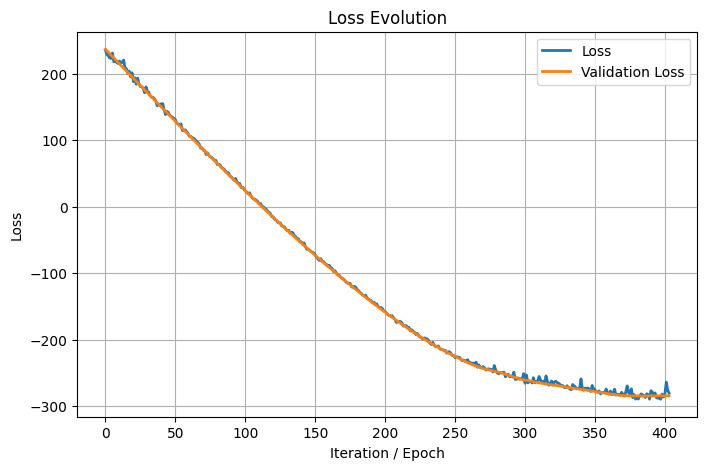

In [11]:
import matplotlib.pyplot as plt
loss_history = output['loss_history']
val_loss = output['val_history']


# Plot            
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label="Loss", linewidth=2)
plt.plot(val_loss, label="Validation Loss", linewidth=2)
plt.xlabel("Iteration / Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()
plt.grid(True)
plt.show()

In [12]:
print(len(output['mu']), sum(p.numel() for p in model.parameters() if p.requires_grad))
print(output['mu'])

150 150
tensor([-9.4875e+00,  1.4437e+00,  1.5328e+00,  1.4177e+00,  1.3444e+00,
         1.9654e+00,  1.6930e+00,  6.3768e-01,  9.7827e-01,  2.1499e+00,
         1.6411e+00,  1.6411e+00, -9.5065e+00,  1.2738e+00,  1.2659e+00,
         1.1725e+00,  1.1729e+00,  1.5386e+00,  1.4945e+00,  1.1779e+00,
         2.0813e+00,  3.8698e+00,  1.6411e+00,  1.6411e+00,  8.1748e-02,
        -3.1356e-02, -8.1687e-03,  4.7886e-02, -5.4799e-02,  6.8153e-02,
        -3.3638e-03,  1.9876e-02,  9.5195e-02,  4.8161e-02, -1.1331e-01,
        -4.6000e-01, -4.6562e-02,  3.1692e-01,  1.1284e-01,  3.7094e-01,
         2.4901e-01, -1.3527e-01, -7.6120e-02, -4.7884e-02, -2.4824e-01,
         4.8596e-01,  3.3286e-01,  3.7120e-02,  2.4936e-01,  2.2391e-01,
        -3.3303e-01, -1.8541e-01,  9.8589e-02,  5.4258e-01,  1.2435e-01,
        -1.7519e-02, -2.7462e-01, -4.8294e-02, -5.7714e-02, -9.4738e-02,
        -7.7130e-02, -7.9272e-02, -2.1730e-02, -1.1031e-01,  6.5358e-02,
         9.2621e-03,  1.3881e-01,  1.3916e-

In [13]:
import torch

def flat_params(model):
    return torch.cat([p.detach().flatten().cpu() for p in model.parameters()])

# snapshot BEFORE
before = flat_params(model).clone()

model.bayesian_param_set(output, update_buffers=False)
# snapshot AFTER
after = flat_params(model)

max_abs_change = (after - before).abs().max().item()
print(f"Max |Δ| across all parameters: {max_abs_change:.3e}")



Max |Δ| across all parameters: 0.000e+00


In [14]:
# pretrain the marginal transformations
#_ = model.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

In [15]:
# train the joint model
#_ = model.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
#                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
#                max_batches_per_iter=False)

### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [16]:
log_likelihood_train_gtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model.log_likelihood(simulated_data_test)

In [17]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [18]:
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )

print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD GTM      Train Data:  0.8206
KLD Gaussian Train Data:  0.1283
KLD Copula   Train Data:  -0.0003
KLD GTM      Test  Data:  0.8139
KLD Gaussian Test  Data:  0.1078
KLD Copula   Test  Data:  0.0041


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as the model splines.

Note that to generate synthetic samples the inverse of the trainsformation layer needs to be approximated  with the method `approximate_transformation_inverse` once which is then stored for future sampling. 

In [19]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)

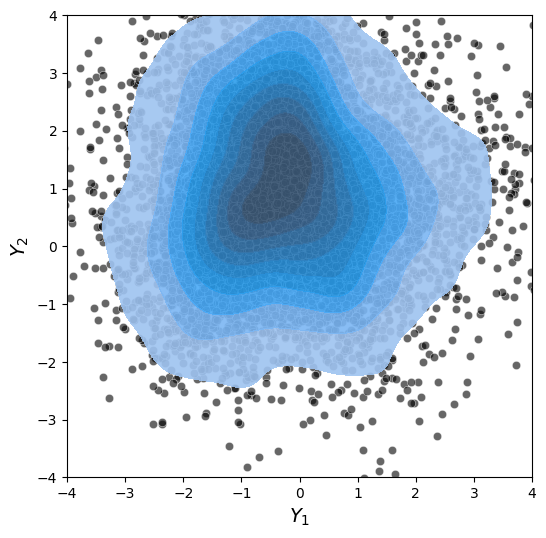

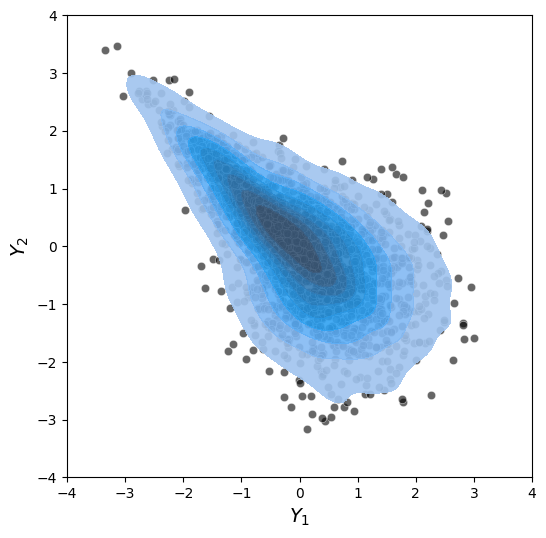

In [20]:
model.plot_densities(synthetic_samples, x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

The varying pseudo conditional correlation matrix values can be computed for any synthetic samples using `compute_pseudo_conditional_correlation_matrix` or can directly be plotted using `plot_conditional_dependence_structure`.
The pseudo conditional correlation matrix is the standardised precision matrix so that off diagonal elements are the pseudo conditional correlations between the respective dimensions.

In [21]:
pseudo_conditional_correlation_matrix = model.compute_pseudo_conditional_correlation_matrix(synthetic_samples)

/Users/franciscocapunay/miniforge3/envs/gtm-magic-env-3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/franciscocapunay/miniforge3/envs/gtm-magic-env-3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


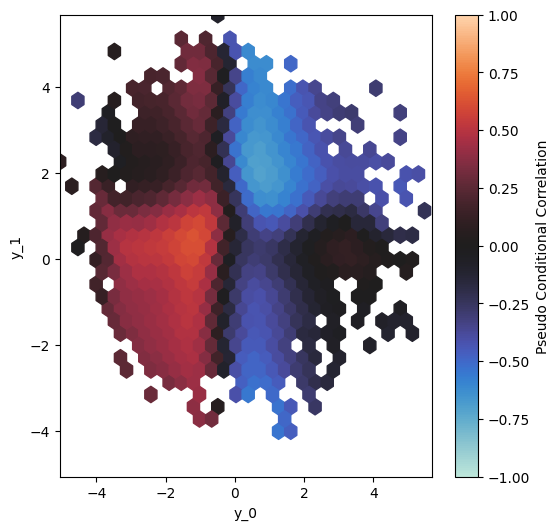

In [22]:
model.plot_conditional_dependence_structure(data=synthetic_samples)

One can also visualize the splines of each layer usign the function `plot_splines`. For the transformation layer we additionally include the dervaitive which is always positive due to the monotonically increasing constraint as well as the inverse which should lie exactly on the spline to visually confirm that the inverse sampling path works.

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


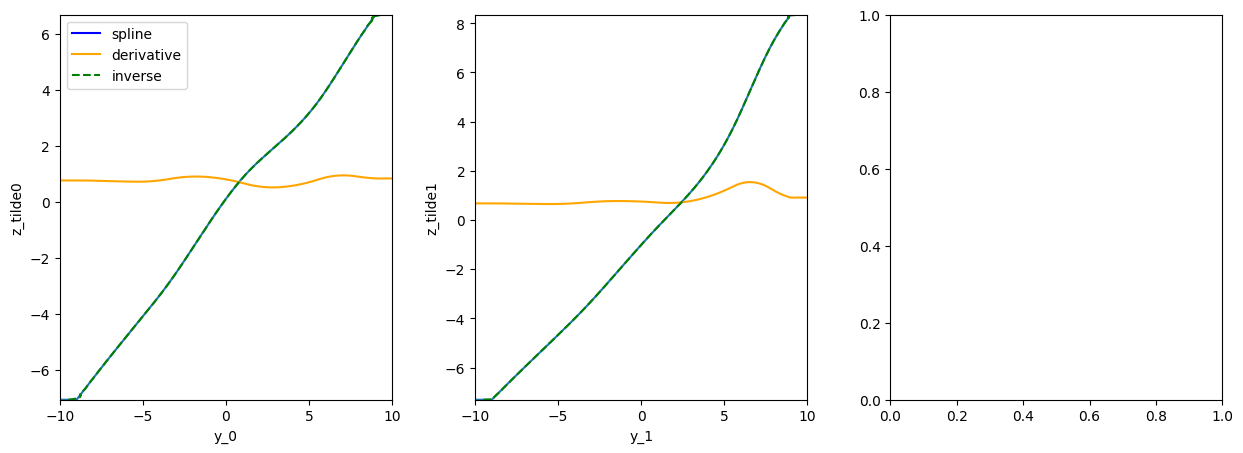

In [23]:
model.plot_splines(layer_type="transformation")

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


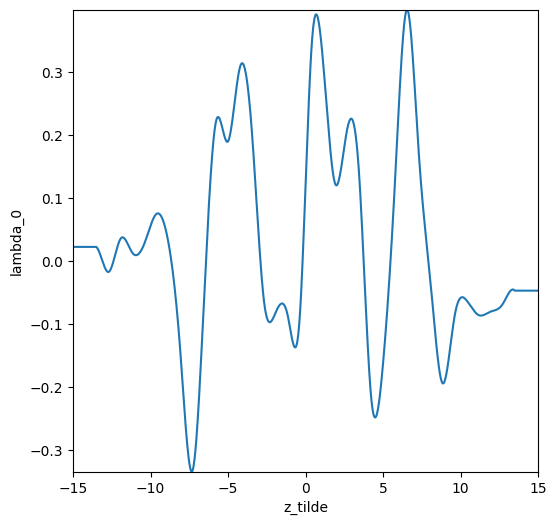

In [24]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


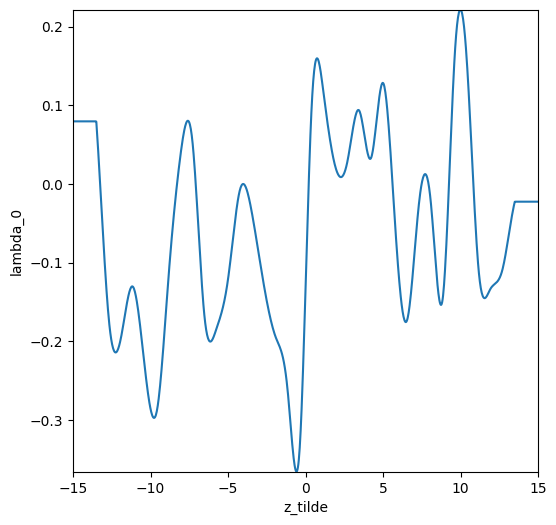

In [25]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


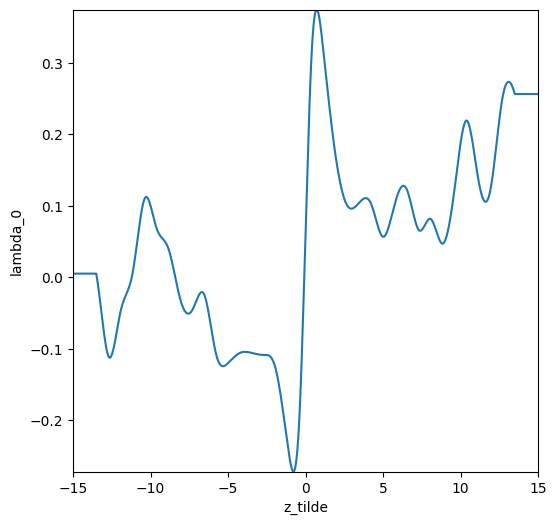

In [26]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)